# Classification

In this notebook we will examine classification success of 16S data collected and analyzed in the Nextflow QIIME2 Pipeline

First, we will collect study IDs, stratified by URT collection area

In [1]:
import glob
import os

ids_NP = glob.glob("/proj/gibbons/nbohmann/metabug/manifest/NP/qiime/*_taxonomy.qza")
ids_NP = [i.split("_")[0].split("/")[-1] for i in ids_NP]
ids_OP = glob.glob("/proj/gibbons/nbohmann/metabug/manifest/OP/qiime/*_taxonomy.qza")
ids_OP = [i.split("_")[0].split("/")[-1] for i in ids_OP]

Now we walk through and read the abundance and format everything nicely to a long DataFrame.

In [2]:
import pandas as pd
from rich.progress import track
from plotnine import *
from utils import qiime_to_dataframe

path_NP = "/proj/gibbons/nbohmann/metabug/manifest/NP/qiime"
path_OP = "/proj/gibbons/nbohmann/metabug/manifest/OP/qiime"


data_NP = []
data_OP = []

for pid_NP in track(ids_NP):
    df = qiime_to_dataframe(f"{path_NP}/{pid_NP}_table.qza", f"{path_NP}/{pid_NP}_taxonomy.qza")
    df["study"] = pid_NP
    df["urt"] = 'Nasopharynx'
    data_NP.append(df)
    
for pid_OP in track(ids_OP):
    df = qiime_to_dataframe(f"{path_OP}/{pid_OP}_table.qza", f"{path_OP}/{pid_OP}_taxonomy.qza")
    df["study"] = pid_OP
    df["urt"] = 'Oropharynx'
    data_OP.append(df)

data_NP = pd.concat(data_NP)
data_OP = pd.concat(data_OP)
data = data_NP.append(data_OP,ignore_index = True)
data['study'] = data['study'].str.replace('PRJEB15534','PRJEB22676')

Output()

Output()

/tmp/ipykernel_2727220/1355404661.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


# Classification Percentage
Now, we'll take a look at overall classification percentage for each taxonomic level

In [5]:
data.loc[data.kingdom == "Unassigned", "kingdom"] = None
ranks = ["kingdom", "phylum", "class", "order", "family", "genus","species"]
cl = pd.Series()
for r in ranks:
    cl[r] = data[data[r].notnull()].reads.sum() / data.reads.sum()
cl

/tmp/ipykernel_2727220/2025534841.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


kingdom    0.933066
phylum     0.925273
class      0.925218
order      0.760628
family     0.752514
genus      0.728839
species    0.085699
dtype: float64

## Classification Dataframe
Let's put together a dataframe of classification percentage for each study, at each taxonomic level. 

In [6]:
import numpy as np

classification = pd.DataFrame()
classification['Study'] = np.nan
for study in data['study'].unique():
    total_reads = data[data['study'].str.contains(study)]['reads'].sum()
    #calculate not-null reads divided by total reads in given study at each rank
    classified_reads_species = data[(data['study'].str.contains(study))&
        (data['species'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    classified_reads_genus = data[(data['study'].str.contains(study))&
        (data['genus'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    classified_reads_family = data[(data['study'].str.contains(study))&
        (data['family'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    classified_reads_order = data[(data['study'].str.contains(study))&
        (data['order'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    classified_reads_class = data[(data['study'].str.contains(study))&
        (data['class'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    classified_reads_phylum = data[(data['study'].str.contains(study))&
        (data['phylum'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    classification = pd.concat([classification, pd.DataFrame({
        'Study':[study],
        'species':[classified_reads_species],
        'genus':[classified_reads_genus],
        'family':[classified_reads_family],
        'order':[classified_reads_order],
        'class':[classified_reads_class],
        'phylum':[classified_reads_phylum]})
                               ])
#format dataframe 
classification = classification[['Study','phylum','class','order','family','genus','species']].set_index('Study')
classification = classification *100 #convert to percentage 
os.chdir('/proj/gibbons/nbohmann/metabug/')
#add disease conditions to dataframe
conditions = pd.read_csv('conditions.csv',index_col = 0,header = None)[1].to_dict()
classification['condition'] = classification.index.map(conditions)
classification = classification.sort_values(by = 'condition')
#save dataframe for supplement
classification.to_csv('/proj/gibbons/nbohmann/metabug/classification.csv')
classification

,phylum,class,order,family,genus,species,condition
Study,,,,,,,
PRJEB22676,68.111613,68.108418,68.099095,67.199091,59.678518,12.522084,Asthma
PRJNA714100,93.716907,93.714802,93.591791,92.704220,91.933568,9.221165,Asthma
PRJNA601757,99.828677,99.828034,95.710318,95.223058,94.645217,14.832858,Asthma
PRJNA543785,95.766116,95.750862,95.745884,93.809078,89.671415,16.355980,COPD
PRJNA704967,99.510048,99.493941,99.451769,96.468421,95.011158,3.779337,COVID
PRJNA707350,99.563654,99.562943,99.521981,98.593821,91.148758,15.038963,COVID
PRJNA673585,99.195734,99.194671,99.062670,97.958372,94.737872,24.618782,COVID
PRJNA240559,97.381860,97.379276,96.260833,96.098878,71.532372,1.502280,Influenza
PRJNA317701,72.920572,72.920572,72.920572,71.548350,68.672564,13.984903,Influenza


## Plot Classification 
Now we'll plot the classification percentage for each study at each level on a heatmap, using Seaborn. We'll add a color bar signifying disease type

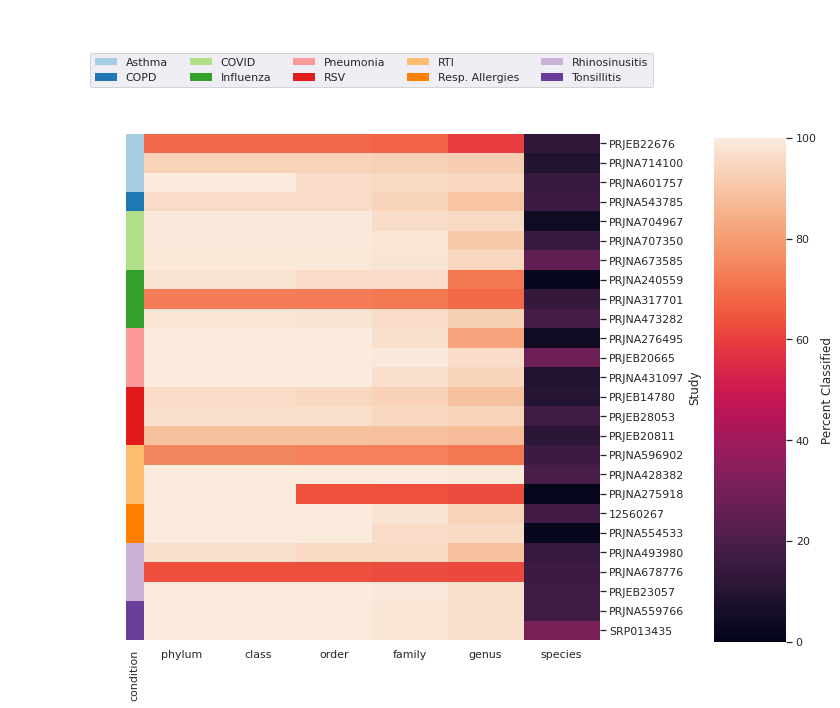

In [8]:
import seaborn as sns
import matplotlib as plt

%matplotlib inline

palette = sns.color_palette("Paired", 11)
lut = dict(zip(classification['condition'].unique(),palette))
row_colors = classification['condition'].map(lut)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.clustermap(classification[['phylum','class','order','family','genus','species']],vmin = 0, 
                    vmax = 100, row_colors=row_colors,row_cluster = False,col_cluster = False,
                    cbar_pos=[1,0.1,.1,.7],cbar_kws={'label':'Percent Classified'})

for label in classification['condition'].unique():
    ax.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
ax.ax_col_dendrogram.legend(loc="center", ncol=5)
ax

## Phyla Distribution
That looks good! Let's look at the phyla distributions on a heatmap. Again we'll use seaborn, and plot phylum abundance for each sample across all studies. 

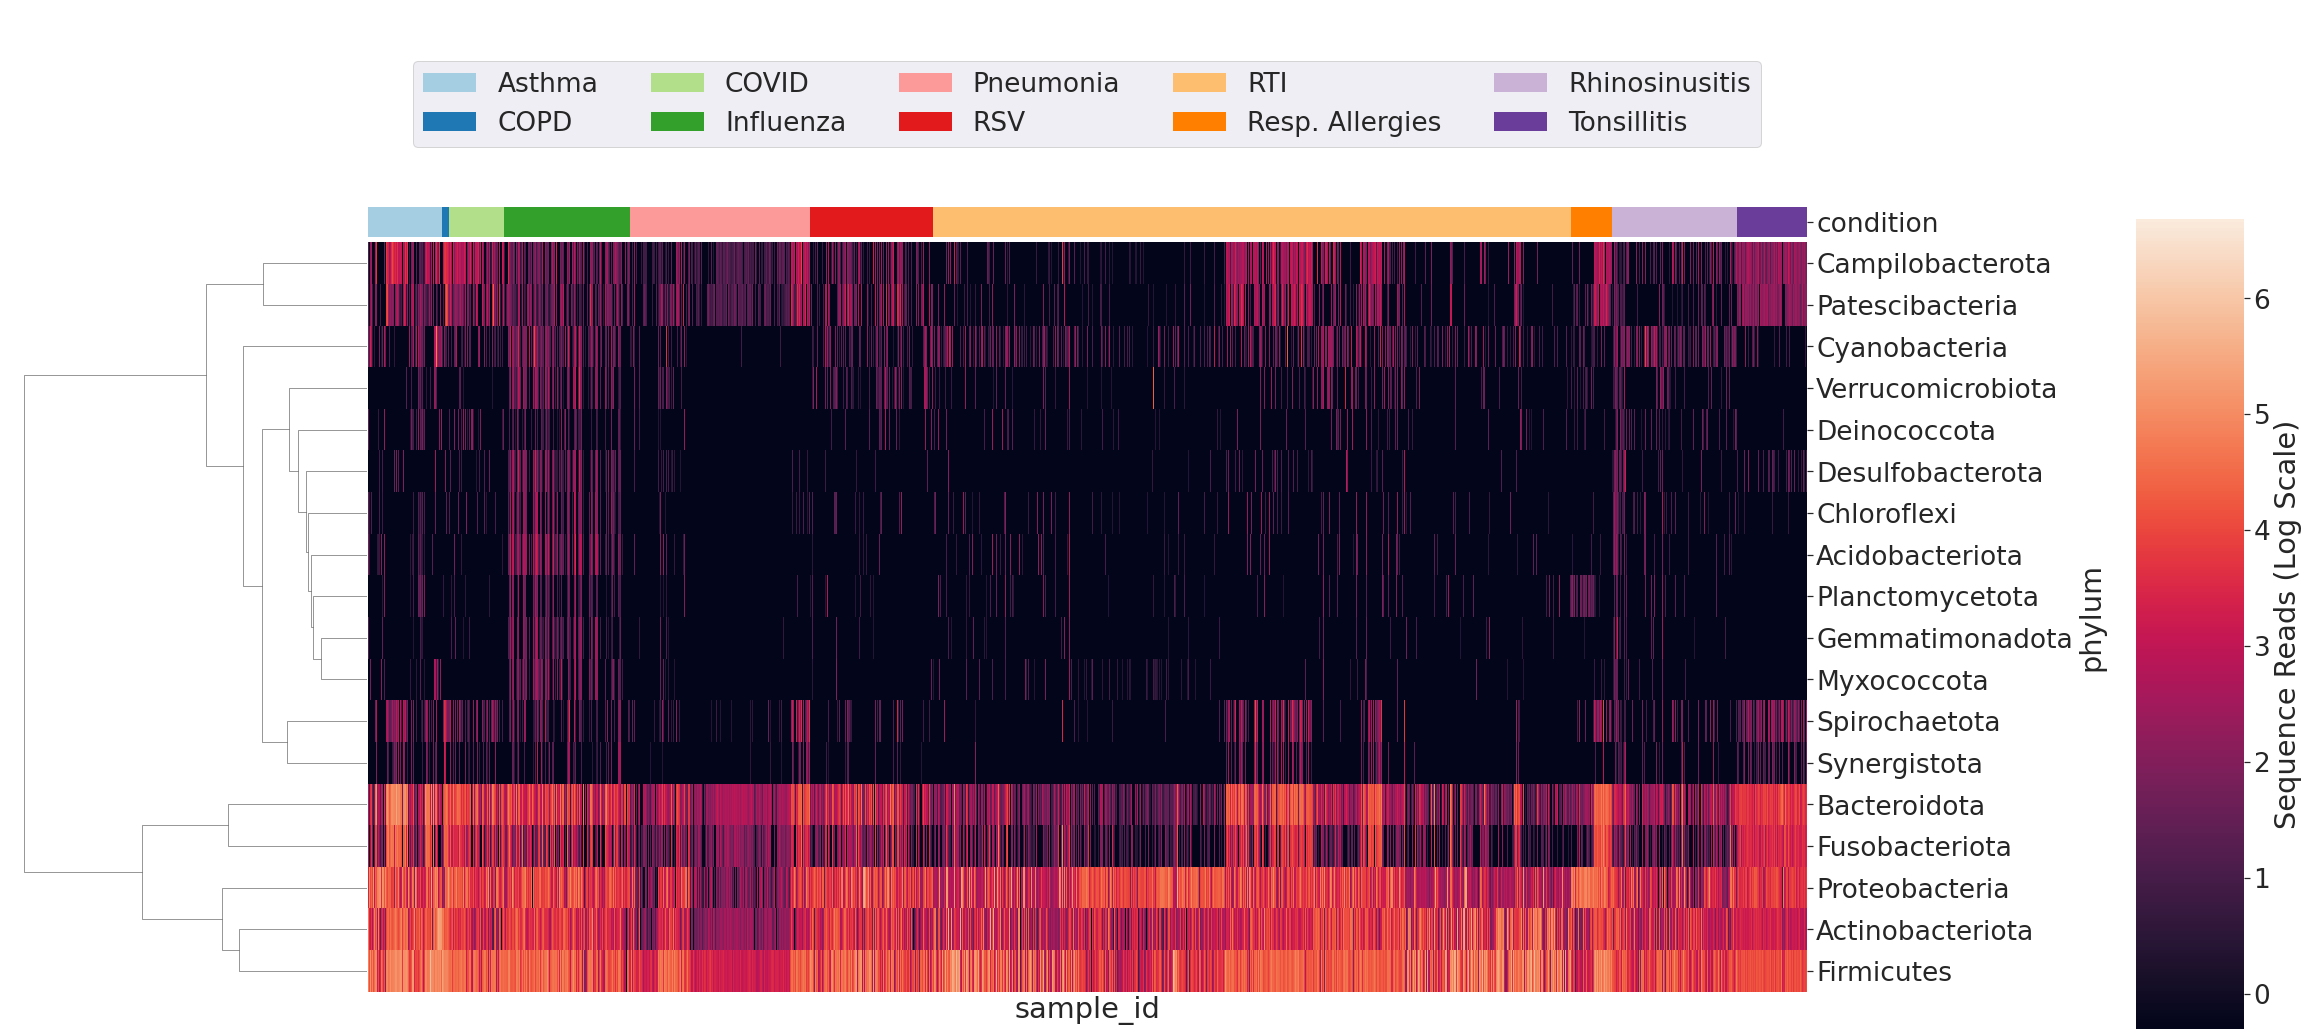

In [9]:
import seaborn as sns
import numpy as np
%matplotlib inline

#pivot data table to phylum abundances 
mat = pd.pivot_table(
    data[(data.kingdom == "Bacteria") & data.genus.notnull()], 
    index="sample_id", 
    values="reads", 
    columns="phylum", 
    aggfunc=sum, 
    fill_value=0.0
)

mat = mat[mat.columns[mat.mean(axis=0) > 5]]
study_dict = data.set_index('sample_id')['study'].to_dict()
mat['study'] = mat.index.map(study_dict)
mat['condition'] = mat['study'].map(conditions)
mat = mat.sort_values(by = 'condition')

lut = dict(zip(mat['condition'].unique(),palette))
row_colors = mat['condition'].map(lut)
sns.set(font_scale=2.4)
x = sns.clustermap(np.log10(mat.iloc[:,:-2].T+0.5), yticklabels=True, 
                   col_colors = row_colors, col_cluster = False, xticklabels=False, 
                   cbar_pos=[1,0.025,.05,.75],figsize=(30, 15), cbar_kws={'label':'Sequence Reads (Log Scale)'})

for label in mat['condition'].unique():
    x.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
x.ax_col_dendrogram.legend(loc="center", ncol=5)